# Instructions

Please follow all tutorial instructions for displaying text and images. If we ask for an image, please make sure it is labeled. If we ask for text, clearly label it and include units. For example, if the question asks for you to **print the wavelength of Hα**, a quantity you have computed, your output might look like the following:

In [1]:
wavelength = 656.3  # in nm, computed elsewhere
print(f'Wavelength of H-alpha: {wavelength} nm.')

Wavelength of H-alpha: 656.3 nm.


For displaying images, it is straight-forward with matplotlib using `plt.imshow(array)`. A few keywords you will find useful are `vmin` and `vmax` which set the image scaling (minimum and maximum value). You can also use the normalizations available from the library `matplotlib.colors`. Please also always use the keyword `origin='lower'`, which sets pixel (0,0) in the lower left corner. An example might look like this: 

`plt.imshow(array, vmin=200, vmax=8000, origin='lower')`

**BOLD** text indicates the output we expect to see for a question. You can use as many cells as you think are necessary for a question, but please do not remove any of the sections or instruction text (so the grader knows what you were trying to do!) Please make sure your methodology is clear, either through comments in the code and/or explicit variable and function names.

> **IMPORTANT!**<br>
> Once you have finished the problem set, reset the kernel and run all of the cells from top to bottom to ensure it works as you expect. We should be able to replicate your results on our own computers by only changing the path to the location of the data files. Don't forget that we also want to know how much total time you spent working on this problem set!

# Package Imports

Import the packages you need. The primary packages you will need are `matplotlib`, `numpy` and `astropy.io.fits`. Please **do not use additional packages** without first checking with the instructors. It's likely we will give you permission if the scope of your intended use does not override the learning goals of this tutorial. 

If you are familiar with (and want to use) `astropy.units` and `astropy.constants`, it may help you keep track of units along the way. Please see the TA if you'd like help implementing its use.

In [2]:
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const
from astropy.table import Table
import numpy as np
from matplotlib import colors
import lmfit
import glob
from lmfit.models import GaussianModel, SplineModel, PolynomialModel
from scipy.signal import find_peaks
import pandas as pd

In [3]:
def plot_data(obj,percentile = [1, 99],use_log = False):
    if(use_log):
        plt.imshow(obj, origin='lower', cmap='gray', clim=(np.percentile(obj,percentile[0]), np.percentile(obj,percentile[1])),norm=colors.LogNorm())
    else:
        plt.imshow(obj, origin='lower', cmap='gray', clim=(np.percentile(obj,percentile[0]), np.percentile(obj,percentile[1])))
    plt.colorbar()
    #plt.ylim(200,600)
    
    

# Part I: Orienting Yourself to the Dataset

1. **Print out a list of available data files (the file extension is `.fits`).** There are also reference files in the subdirectory `reference`. **Print out these file names as well.**

In [4]:
files = glob.glob("./problemset3data/*.fits")
files

['./problemset3data/star.fits',
 './problemset3data/flat00.fits',
 './problemset3data/bias02.fits',
 './problemset3data/dark00.fits',
 './problemset3data/dark04.fits',
 './problemset3data/science03.fits',
 './problemset3data/arc01.fits',
 './problemset3data/dark01.fits',
 './problemset3data/flat01.fits',
 './problemset3data/dark03.fits',
 './problemset3data/dark02.fits',
 './problemset3data/arc00.fits',
 './problemset3data/bias04.fits',
 './problemset3data/bias03.fits',
 './problemset3data/science00.fits',
 './problemset3data/science04.fits',
 './problemset3data/trace.fits',
 './problemset3data/science02.fits',
 './problemset3data/flat02.fits',
 './problemset3data/arc02.fits',
 './problemset3data/bias01.fits',
 './problemset3data/bias00.fits',
 './problemset3data/science01.fits']

2. Choose one file and explore the fits header keywords and think about what they all represent. Click [here](https://docs.astropy.org/en/stable/io/fits/index.html) to access Astropy's documentation for working with FITS files. You can print an easier-to-read header if you use `print(repr(header))` rather than just `print(header)`. **Print the header with keywords and their values.**

In [5]:
chosen_file = files[0]
open_file = fits.open(chosen_file)
header_file = open_file[0].header
print(repr(header_file))
SPASCALE = header_file["SPASCALE"]
SPESCALE = header_file["SPESCALE"]
SLITWIDT = header_file["SLITWIDT"]
SLITLEN = header_file["SLITLEN"]
header_file["OBJECT"]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024 / length of spectral axis                        
NAXIS2  =                 1024 / length of spatial axis                         
EXTEND  =                    T                                                  
BUNIT   = 'ADU     '           / physical units of the array values             
EPOCH   = 'J2000   '           / equinox of celestial coordinate system         
DATE-OBS= '2021-06-08T13:34:18.483' / date of the observation                   
TELESCOP= 'Keck I  '           / name of telescope                              
INSTRUME= 'LORES   '           / name of instrument                             
OBSTYPE = 'SCIENCE '           / type of observation                            
TARGET  = 'MITCH''S STAR'   

"MITCH'S STAR"

3. Construct an observation log. For each file you found above, the table should include:<br><br>
&nbsp; &nbsp; &nbsp; &nbsp; 1\. The file name,<br>
&nbsp; &nbsp; &nbsp; &nbsp; 2\. The observation date and time,<br>
&nbsp; &nbsp; &nbsp; &nbsp; 3\. The image type,<br>
&nbsp; &nbsp; &nbsp; &nbsp; 4\. The target name,<br>
&nbsp; &nbsp; &nbsp; &nbsp; 5\. The exposure time,<br>
&nbsp; &nbsp; &nbsp; &nbsp; 6\. The target right ascension,<br>
&nbsp; &nbsp; &nbsp; &nbsp; 7\. The target declination, and<br>
&nbsp; &nbsp; &nbsp; &nbsp; 8\. The airmass.<br><br>
Make sure your table has a title on every column, including units when relevant. **Print out an in-line log table.**

In [6]:
Obslog = Table(
                    names=("File", "UTC", "ra", "dec", "targetid", "objid", "airmass", "exptime", "obstype"
                    ),
                    meta={"name": "Observation Log"},
                    dtype=("U64", "U64", "U64", "U64", "U64", "U64", "float64", "float64", "U64"
                          )
                    )
for i in files:
      open_file = fits.open(i)
      header_file = open_file[0].header
      row = [i, header_file["DATE-OBS"], header_file["RA"],
             header_file["DEC"], header_file["TARGET"], header_file["OBJECT"], 
             header_file["AIRMASS"], header_file["EXPTIME"], header_file["OBSTYPE"]]
      Obslog.add_row(row)
Obslog

File,UTC,ra,dec,targetid,objid,airmass,exptime,obstype
str64,str64,str64,str64,str64,str64,float64,float64,str64
./problemset3data/star.fits,2021-06-08T13:34:18.483,22:19:31.3,-13:25:55.0,MITCH'S STAR,MITCH'S STAR,1.398068424041609,1.0206,SCIENCE
./problemset3data/flat00.fits,2021-06-08T13:03:10.525,19:49:48.4,+19:49:42.0,FLATLAMP,FLATLAMP,1.0,10.021,FLAT
./problemset3data/bias02.fits,2021-06-08T13:01:00.172,19:47:37.7,+19:49:42.0,NONE,NONE,1.0,0.0,BIAS
./problemset3data/dark00.fits,2021-06-08T13:06:47.663,19:53:26.2,+19:49:42.0,NONE,NONE,1.0,300.1633,DARK
./problemset3data/dark04.fits,2021-06-08T13:28:48.362,20:15:30.5,+19:49:42.0,NONE,NONE,1.0,300.0302,DARK
./problemset3data/science03.fits,2021-06-08T13:51:20.129,22:15:55.2,333:58:47.5,GANYMEDE,GANYMEDE,1.3,300.0597,SCIENCE
./problemset3data/arc01.fits,2021-06-08T13:05:43.319,19:52:21.7,+19:49:42.0,ARCLAMP,ARCLAMP,1.0,2.1645,ARC
./problemset3data/dark01.fits,2021-06-08T13:12:17.992,19:58:57.4,+19:49:42.0,NONE,NONE,1.0,300.0945,DARK
./problemset3data/flat01.fits,2021-06-08T13:03:50.571,19:50:28.6,+19:49:42.0,FLATLAMP,FLATLAMP,1.0,10.0827,FLAT


4. The files in this set include bias frames, flats, arc frames, dark frames, a trace frame, a calibration star frame and science frames. Display at least one of the science images to orient yourself to what raw data looks like. **Display the data in one of the science frames. Don't forget to title it with the name of the object from the FITS header.**

> **NOTE**<br>
> When reading in data from a FITS file, always make sure to convert the data type to floating-point numbers. If you don't, math you perform on the images later in the notebook may produce strange results. If you've opened your FITS file with `astropy.io.fits` and stored it in a variable called `hdul`, and you want to store the data from the primary extension in a variable called `data`, you might do it like this:
> `data = hdul['PRIMARY'].data.astype(float)`

Text(0.5, 1.0, "MITCH'S STAR")

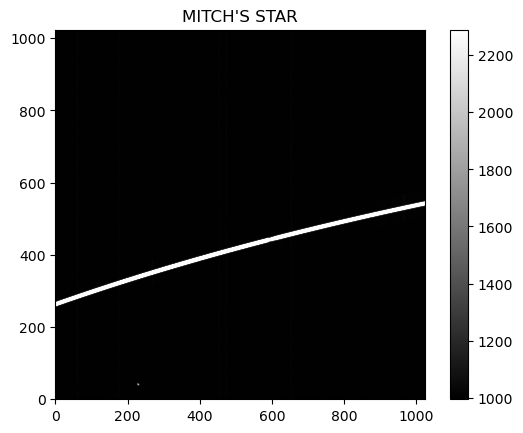

In [7]:
test = Obslog[np.where((Obslog["targetid"] == "MITCH'S STAR"))]
chosen_file = test[0]["File"]
open_file = fits.open(chosen_file)
header_file = open_file[0].header
data = open_file['PRIMARY'].data.astype(float)
plot_data(data)
plt.title(header_file["OBJECT"])

# Part II: Data Reduction

5. Median combine the bias images to create a master bias. **Display your master bias.** Don't forget the colorbar and a title! How well does the bias level match that listed in the FITS header?

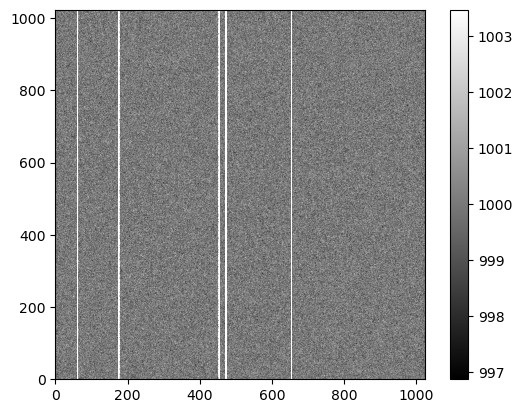

In [8]:
def read_file(file_name):
    return fits.open(file_name)['PRIMARY'].data.astype(float)

bias_table = Obslog[np.where((Obslog["obstype"] == "BIAS"))]
bias_data = []
for i in bias_table:
    bias_data.append(read_file(i["File"]))
bias_data = np.asarray(bias_data)
bias = np.median(bias_data, axis = 0)
plot_data(bias)


6. Create a normalized master flat. To do this:<br><br>
&nbsp; &nbsp; &nbsp; &nbsp; 1\. Subtract the master bias from each flat image,<br>
&nbsp; &nbsp; &nbsp; &nbsp; 2\. Divide the images by their individual exposure times,<br>
&nbsp; &nbsp; &nbsp; &nbsp; 3\. Median-combine all the flat images, and<br>
&nbsp; &nbsp; &nbsp; &nbsp; 4\. Normalize the result (you can either normalize by the maximum value, the average value, or the median value).<br><br>
**Display your normalized master flat.**

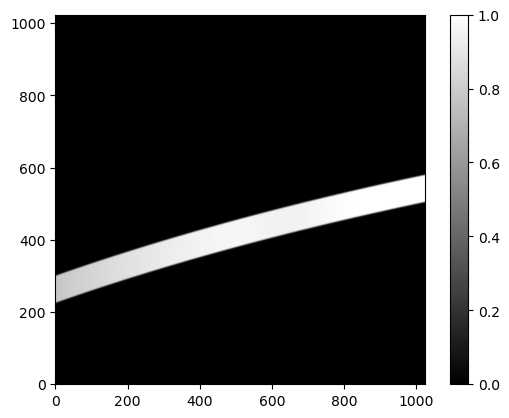

In [9]:

flat_table = Obslog[np.where((Obslog["obstype"] == "FLAT"))]
flat_data = []
for i in flat_table:
    flat_data.append((read_file(i["File"]) - bias) / i["exptime"])
flat_data = np.median(np.asarray(flat_data), axis=0)
flat = flat_data/np.percentile(flat_data, 99)
plot_data(flat)


7. Create a master arc. The process is the same as the flat without the normalization step. **Display your master arc.**

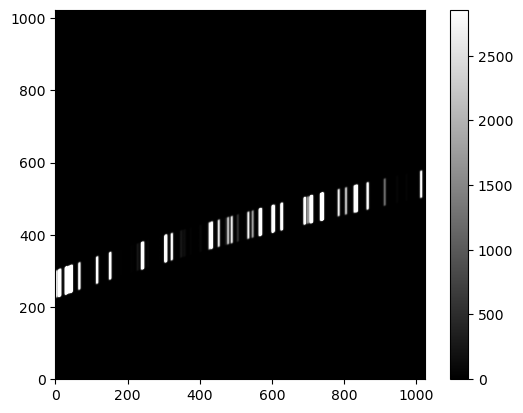

In [10]:

arc_table = Obslog[np.where((Obslog["obstype"] == "ARC"))]
arc_data = []
for i in arc_table:
    arc_data.append((read_file(i["File"]) - bias) / i["exptime"])
arc = np.median(np.asarray(arc_data), axis=0)
plot_data(arc)

8. Create a master dark. Like the master arc, the process is the same as the flat without the normalization step. **Display your master dark.**

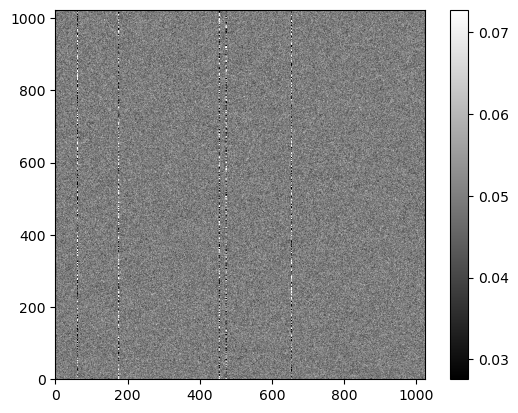

In [11]:

dark_table = Obslog[np.where((Obslog["obstype"] == "DARK"))]
dark_data = []
for i in dark_table:
    dark_data.append((read_file(i["File"])  - bias) / i["exptime"])
dark = np.median(np.asarray(dark_data), axis=0)
plot_data(dark)

# Part III: Order Rectification

9. Load the detector trace image and subtract the master bias. Find the pixel coordinates for the bright line. The line you've found is called the "trace." **Display the trace image and plot your trace on top.**

array([261.41529957, 261.76683273, 262.11901869, ..., 540.37212315,
       540.57987989, 540.80129051])

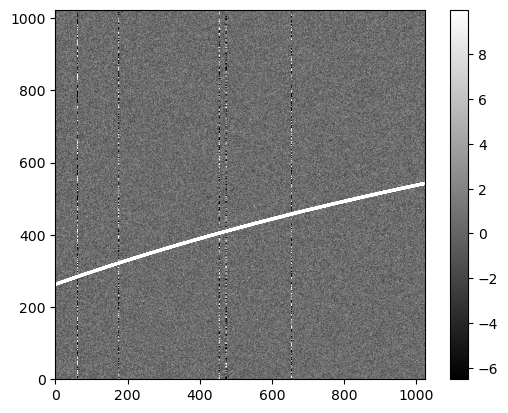

In [12]:
trace_table = Obslog[np.where((Obslog["obstype"] == "TRACE"))]
trace_data = []
for i in trace_table:
    trace_data.append(read_file(i["File"])-bias)
trace_data = np.asarray(trace_data)
trace = np.median(trace_data, axis = 0)
plot_data(trace)
window = 10

peak = []
x = np.arange(trace.shape[0])

for i in range(trace.shape[1]):
    column = trace[:,i]
    arg_max = np.argmax(column)
    model = GaussianModel()
    params = model.guess(column, x = x)
    result = model.fit(column, params, x = x)
    peak.append(result.params["center"].value)
peak = np.asarray(peak)
peak

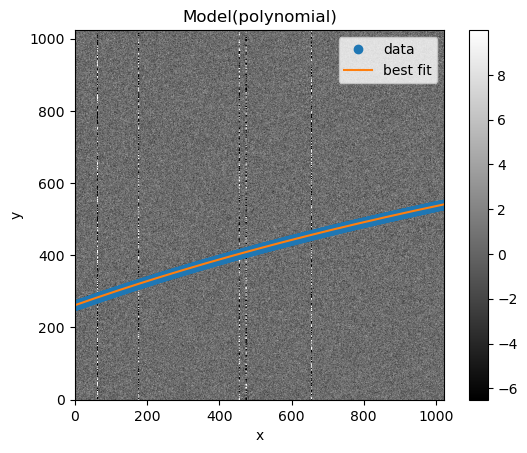

In [13]:
s_model = PolynomialModel(degree = 7)
s_params = s_model.guess(peak, x = x)
s_result = s_model.fit(peak, s_params, x = x)
s_result.plot_fit()
plot_data(trace)

10. Use the trace to rectify the master bias, master flat, master arc and master dark. You want to select only the region of the detector with data (the bright region in the master flat). You don't want to include anything outside of this region. Also rectify the trace to check that the rectification worked as expected (the bright line should appear horizontal.)  **Display the rectified master images and the trace.**

In [14]:
slitlen_pixel = SLITLEN / SPASCALE
slitlen_pixel

75.0

In [15]:
trace_line = s_model.eval(s_params, x = x)
trace_line_min = np.floor(trace_line - slitlen_pixel/2).astype(int)
trace_line_max = np.ceil(trace_line + slitlen_pixel/2).astype(int)

In [16]:
def rectify(data):
    rectangle = []
    for i in range(data.shape[1]):
        column = data[:,i]
        rectangle.append(column[trace_line_min[i]:trace_line_max[i]])
    rectangle = np.asarray(rectangle)
    return rectangle.T

In [17]:
rectify_bias = rectify(bias)
rectify_bias

array([[1000.53348278,  998.93082006, 1000.12642112, ...,  999.47639335,
         999.0032278 , 1001.34175139],
       [1000.4215244 ,  999.16520652, 1001.47165236, ...,  999.47043212,
         999.12704402, 1003.78522751],
       [1001.33497266, 1000.18726252, 1001.9727159 , ...,  995.61608021,
         998.71273647, 1002.79987562],
       ...,
       [ 999.7418604 ,  999.32346161,  999.38242656, ...,  998.37407188,
        1001.74230534, 1000.59262674],
       [ 999.4367614 ,  997.31671161,  999.98631618, ...,  999.33954917,
        1001.01257678,  999.3204639 ],
       [ 997.72772088, 1000.21370281, 1003.42191925, ..., 1002.80918218,
        1000.63244217,  998.31049741]])

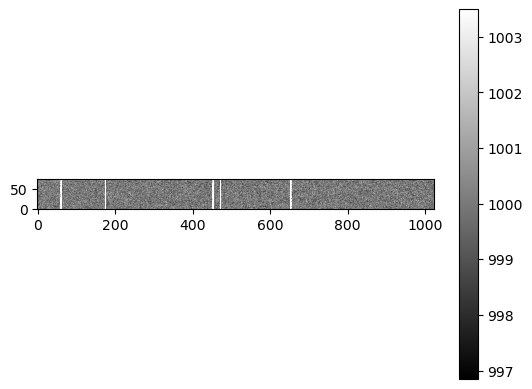

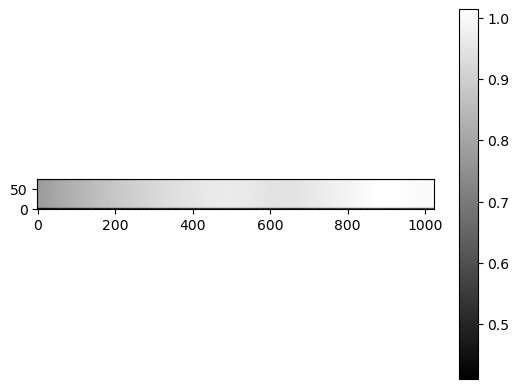

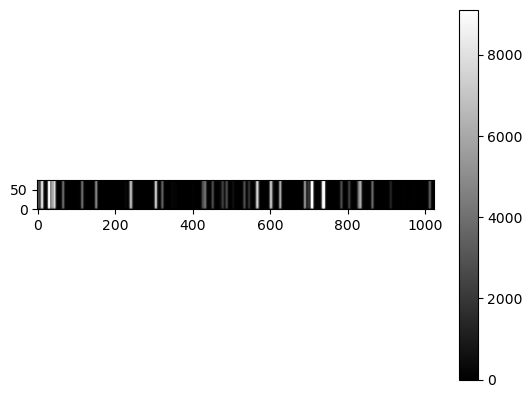

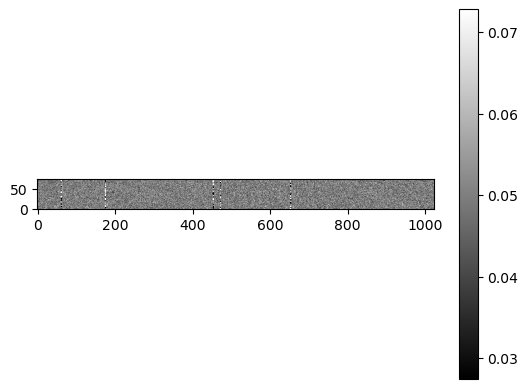

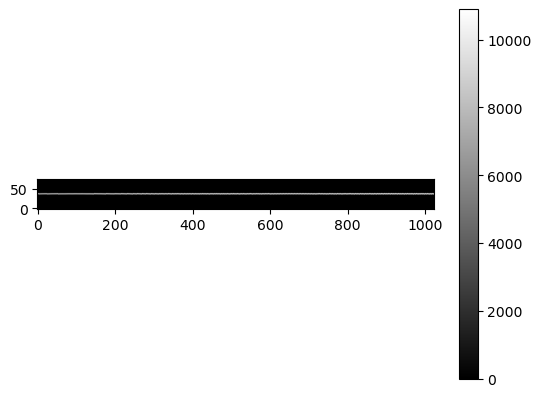

In [18]:
rectify_bias = rectify(bias)
plot_data(rectify_bias)
plt.show()
rectify_flat = rectify(flat)
plot_data(rectify_flat)
plt.show()
rectify_arc = rectify(arc)
plot_data(rectify_arc)
plt.show()
rectify_dark = rectify(dark)
plot_data(rectify_dark)
plt.show()
rectify_trace = rectify(trace)
plot_data(rectify_trace)
plt.show()

# Part IV: Wavelength Calibration

11. Make a one-dimensional arc spectrum and find the pixel coordinates of as many peaks as you can (7 minimum!) **Display the one-dimensional spectrum and the locations of the peaks you've found.**

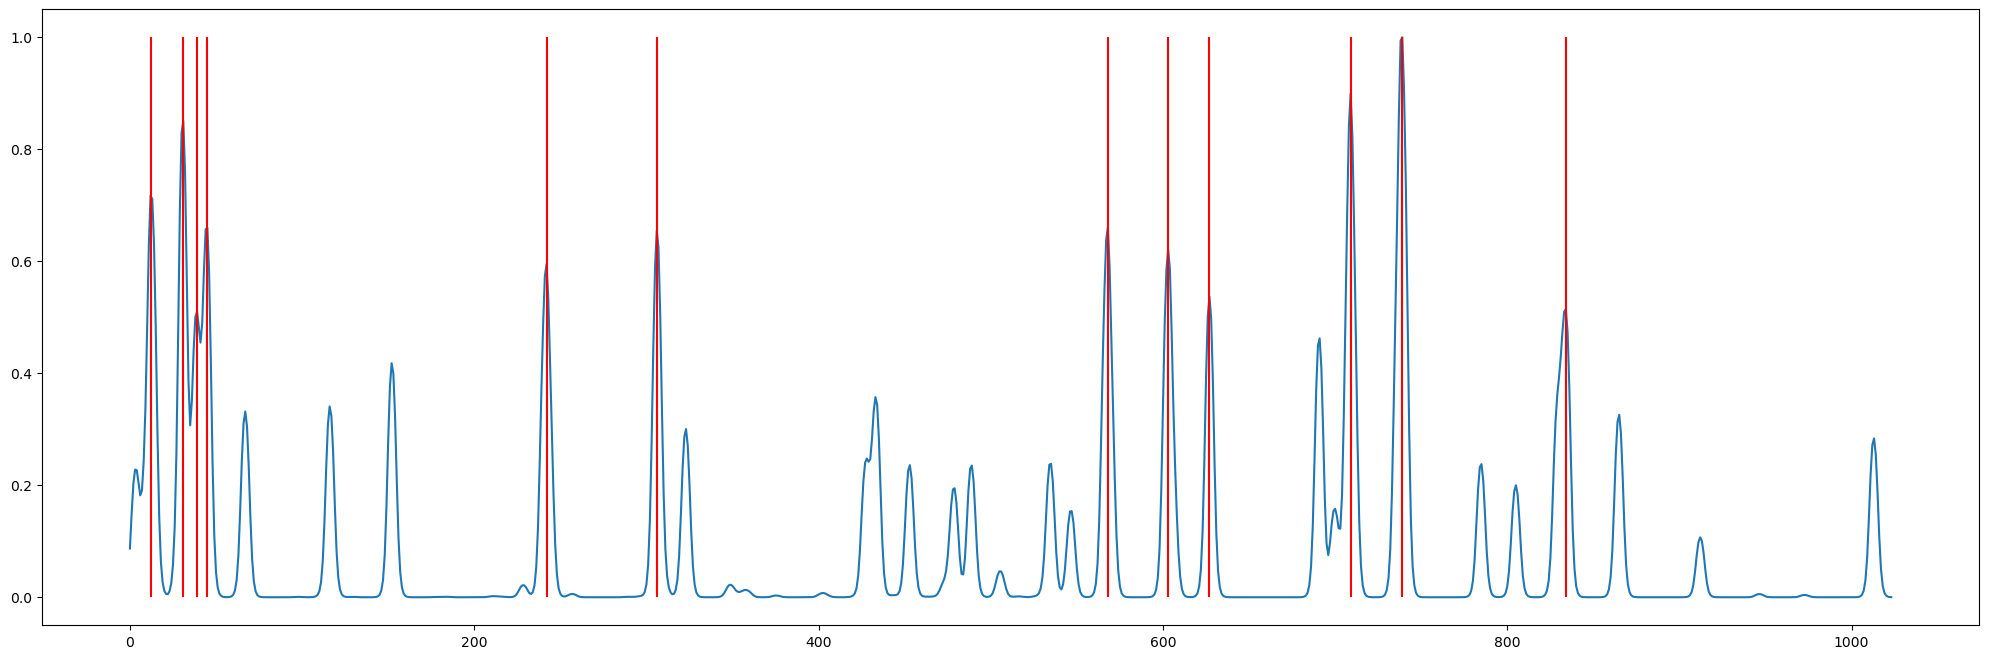

In [19]:
plt.figure(figsize=(25,8))
oned_spectra = np.sum(rectify_arc, axis = 0)
oned_spectra_norm = oned_spectra/np.max(oned_spectra)
plt.plot(oned_spectra_norm)
oned_spectra_norm.shape
peaks = find_peaks(oned_spectra_norm, height=0.5)[0]
for i in peaks:
    plt.vlines(i, np.min(oned_spectra_norm), np.max(oned_spectra_norm), color = "red")
plt.show()

12. Use the reference spectra plots included with the data to figure out the wavelengths of the peaks you've found. Fit a polynomial to the peaks and the wavelengths to calculate the "wavelength solution." The goal is to assign a wavelength to each horizontal pixel. Make this a function which takes pixel number as an input and outputs wavelength. **Scatterplot the peaks (pixel positions) and wavelengths you assigned to them. Overplot your wavelength solution.**

>**CAUTION**
> Be careful of blended lines! A line may appear to be a single peak in your arc spectrum but show up as multiple, separate peaks in the reference plots.

In [20]:
peak_lambda = [506.811, 515.962, 519.912, 523.112, (617.022 + 618.272)/2, 645.725, (750.385 + 751.485)/2, 763.486, 772.387, 801.490, (810.391 + 811.541)/2, 842.444]
print(len(peak_lambda))
print(len(peaks))
for i, j in zip(peaks, peak_lambda):
    window = 10
    section = oned_spectra_norm[i - window: i + window]
    #plt.title(j)
    #plt.plot(section)
    #plt.show()

12
12


In [21]:
l_model = PolynomialModel(degree = 3)
l_params = l_model.guess(peak_lambda, x = peaks)
l_result = l_model.fit(peak_lambda, l_params, x = peaks)
wavelenths = l_model.eval(l_result.params, x = range(0,len(oned_spectra_norm)))
wavelenths

array([500.11043473, 500.63143316, 501.15211902, ..., 899.33677411,
       899.62709427, 899.9172753 ])

Text(0, 0.5, 'wavelength (nm)')

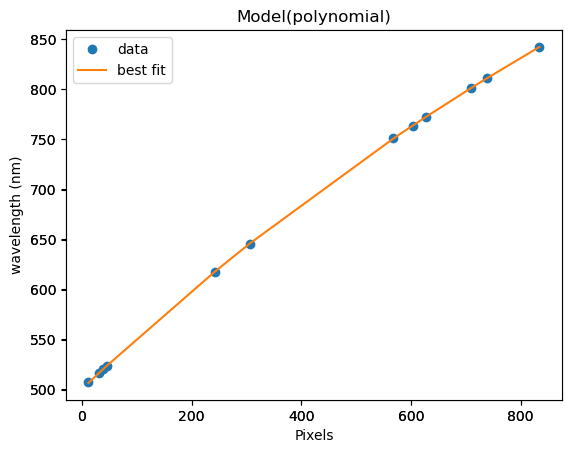

In [22]:
plt.scatter(peaks, peak_lambda)
l_result.plot_fit()
plt.xlabel("Pixels")
plt.ylabel("wavelength (nm)")

Text(0.5, 0, 'wavelength (nm)')

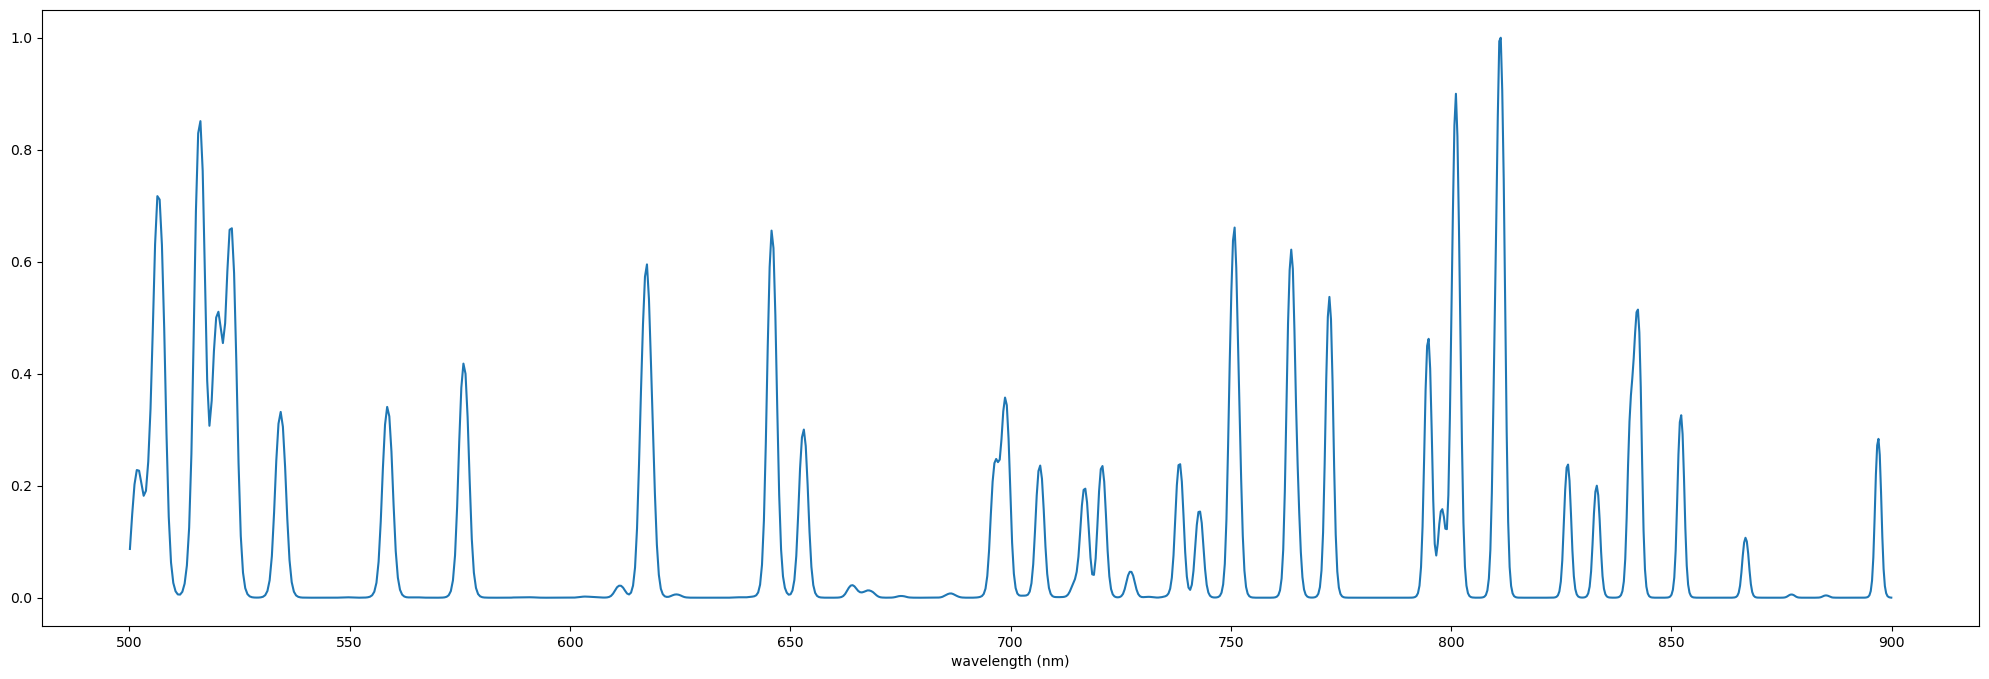

In [23]:
plt.figure(figsize=(25,8))
plt.plot(wavelenths, oned_spectra_norm)
plt.xlabel("wavelength (nm)")

13. Calculate the spectral resolution (resolving power) for each wavelength. Remember, resolving power $R$ at any wavelength $\lambda$ is defined by<br><br>
$R = \frac{\lambda}{\Delta\lambda}.$<br>
**Plot resolving power vs. wavelength for this spectrograph. Print the resolving power at the center of the wavelength range you found with your fit.**

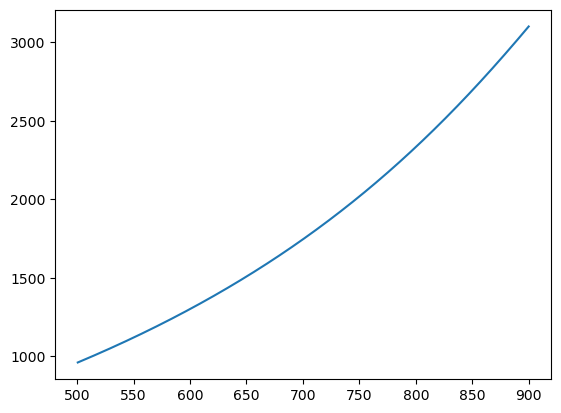

In [24]:
R = []
for i in range(1,len(wavelenths)):
    prev = wavelenths[i - 1]
    curr = wavelenths[i]
    deltaL = curr - prev
    R.append(curr/deltaL)
R = np.asarray(R)
plt.plot(wavelenths[1:len(wavelenths)], R)

# Part V: Flux Calibration

## Source Extraction

14. Load the star calibration file, rectify and reduce the data. Decide on an appropriate aperture: choose the number of rows which reasonably contain the signal from the star). **Display an image of the reduced, rectified star data and plot the boundaries of your extraction aperture on top of it.**

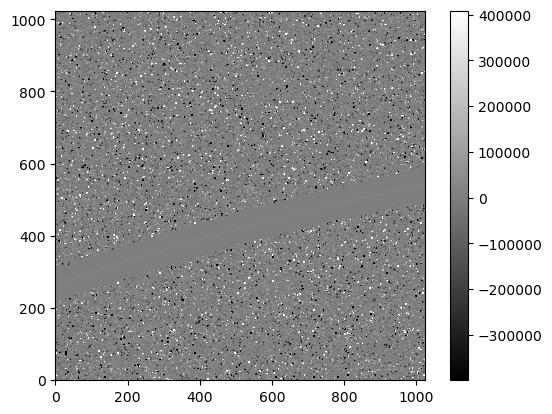

In [25]:
std_star_row = Obslog[np.where(Obslog["targetid"] == "MITCH'S STAR")][0]
std_star = (((read_file(std_star_row["File"]) - bias) / std_star_row["exptime"])) / flat
plot_data(std_star)

In [26]:
std_star_row

File,UTC,ra,dec,targetid,objid,airmass,exptime,obstype
str64,str64,str64,str64,str64,str64,float64,float64,str64
./problemset3data/star.fits,2021-06-08T13:34:18.483,22:19:31.3,-13:25:55.0,MITCH'S STAR,MITCH'S STAR,1.398068424041609,1.0206,SCIENCE


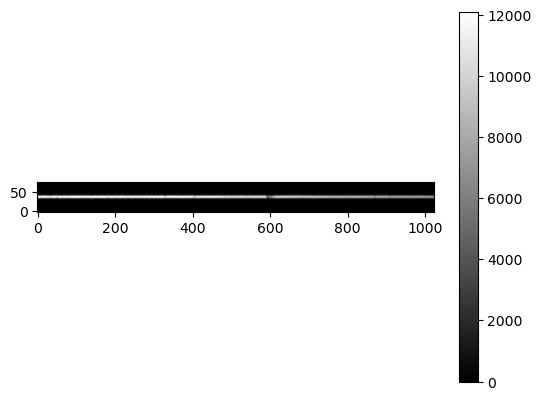

In [27]:
std_star_rec = rectify(std_star)
plot_data(std_star_rec)

<AxesSubplot: title={'center': 'Model(gaussian)'}, xlabel='x', ylabel='y'>

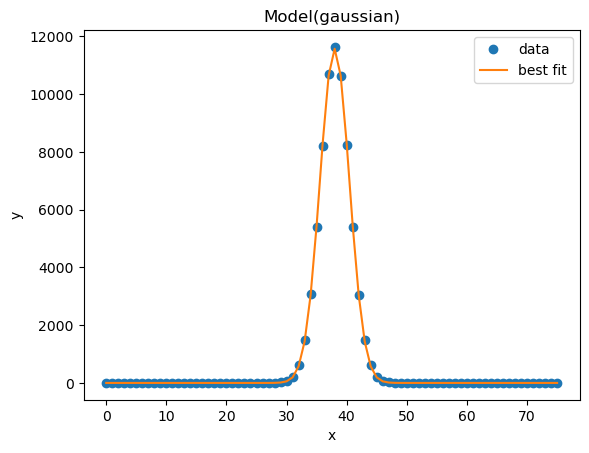

In [28]:
std_star_vertical = np.median(std_star_rec, axis = 1)
p = np.arange(len(std_star_vertical))

model = GaussianModel()
params = model.guess(std_star_vertical, x = p)
result = model.fit(std_star_vertical, params, x = p)
result.plot_fit()

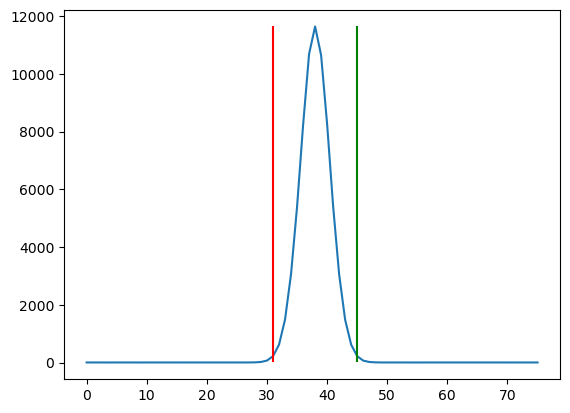

In [29]:
gauss_c = result.params["center"]
gauss_s = result.params["sigma"]
scaler = 3
l_bound = int(np.ceil(gauss_c - scaler * gauss_s))
r_bound = int(np.floor(gauss_c + scaler * gauss_s))

plt.plot(p, std_star_vertical)
plt.vlines(l_bound, np.min(std_star_vertical), np.max(std_star_vertical), color = "red")
plt.vlines(r_bound, np.min(std_star_vertical), np.max(std_star_vertical), color = "green")

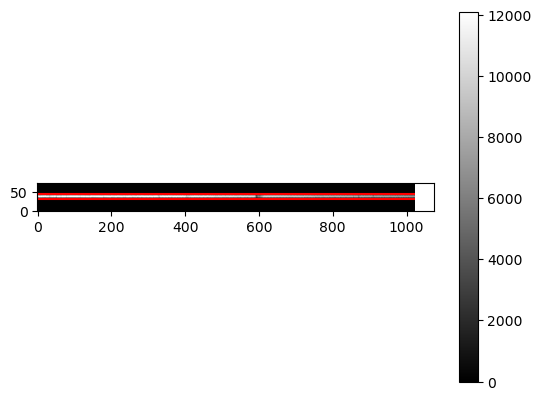

In [30]:
std_star_rec = rectify(std_star)
plot_data(std_star_rec)

plt.hlines(l_bound, 0, std_star_rec.shape[1], color = "red")
plt.hlines(r_bound, 0, std_star_rec.shape[1], color = "red")

In [31]:
spectra_reduced = []
star_pixels = l_bound - r_bound
sky_pixels = std_star_rec.shape[0] - star_pixels
for i in range(std_star_rec.shape[1]):
    col = std_star_rec[:,i]
    col_star = col[l_bound:r_bound]
    #col_sky_l = col[0:l_bound]
    #col_sky_r = col[r_bound:std_star_rec.shape[0]]
    #col_sky = np.append(col_sky_l,col_sky_r)
    #sky_r = np.median(col_sky)
    star_s = np.sum(col_star)
    spectra_reduced.append(star_s)
spectra_reduced = np.asarray(spectra_reduced)
spectra_reduced.shape


(1024,)

15. Extract the one-dimensional spectrum from the aperture (you need all the signal from the star, so you should use a sum, not an average or median). **Plot the one-dimensional spectrum against wavelength.**

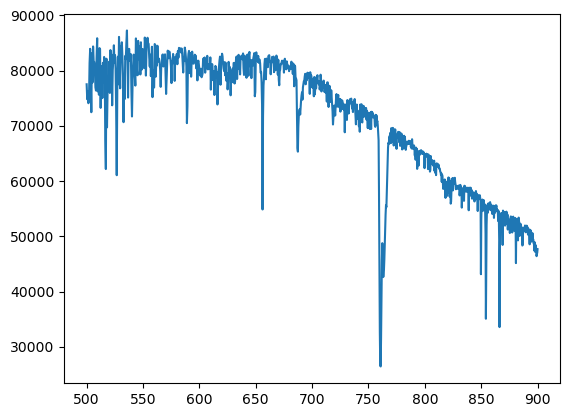

In [32]:
plt.plot(wavelenths, spectra_reduced)

16. The stellar photons traveled through the atmosphere with some non-zero airmass, so we need to correct for that. The idea is to equalize every observation to the same airmass (typically "airmass zero," or what would be observed from just above the atmosphere in space, but still at Earth). Load the airmass extinction data in the file `mauna_kea_airmass_extinction.dat` from [Buton et al. (2003)](http://dx.doi.org/10.1051/0004-6361/201219834). The first column is wavelength in nanometers, the second is the extinction at that wavelength in magnitudes/airmass. If you remember the definition of magnitude,<br><br>
$\Delta m = -2.5\log_{10}\left(\frac{F}{F_0}\right),$<br>
the quantity in the data is $F$, and if you multiply the extinction by the airmass, you'll get $\Delta m$ at each wavelength. Solving for $F_0$,<br><br>
$F_0 = F \times 10^{\frac{\Delta m}{2.5}}.$<br>
Calculate the wavelength-dependent airmass extinction for the stellar spectrum and calculate the zero airmass flux. **Plot both and clearly indicate which is which.** Does the difference between the two plots make sense?

In [33]:
def F0(F, delta_m):
    return 10**(delta_m/2.5) * F

In [34]:
mauna_kea_airmass = Table.from_pandas(pd.read_csv("problemset3data/reference/mauna_kea_airmass_extinction.dat", delimiter=" "))

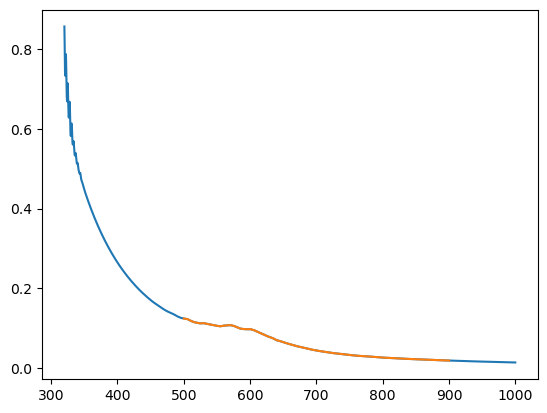

In [35]:
mauna_kea_interp = np.interp(wavelenths, mauna_kea_airmass["wavelength"], mauna_kea_airmass["magnitude"])
plt.plot(mauna_kea_airmass["wavelength"], mauna_kea_airmass["magnitude"])
plt.plot(wavelenths, mauna_kea_interp)

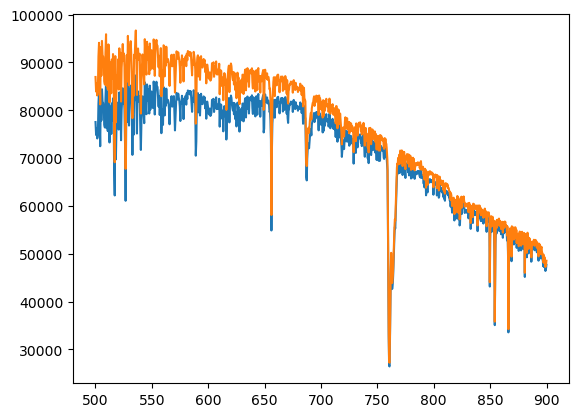

In [36]:
F0_std_star = F0(spectra_reduced, mauna_kea_interp)
plt.plot(wavelenths, spectra_reduced)
plt.plot(wavelenths, F0_std_star)

## Background Removal

17. Like in the imaging tutorial, calculate the background by using the area just above and below the aperture, but not too close to the upper and lower edges of the slit. **Display an image of the reduced, rectified star data and plot the boundaries of your chosen background region on top of it.**

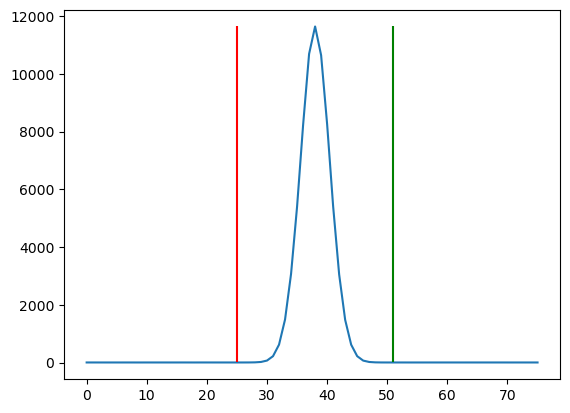

In [37]:
scaler_s = 5
l_bound_s = int(np.floor(gauss_c - scaler_s * gauss_s))
r_bound_s = int(np.ceil(gauss_c + scaler_s * gauss_s))

plt.plot(p, std_star_vertical)
plt.vlines(l_bound_s, np.min(std_star_vertical), np.max(std_star_vertical), color = "red")
plt.vlines(r_bound_s, np.min(std_star_vertical), np.max(std_star_vertical), color = "green")

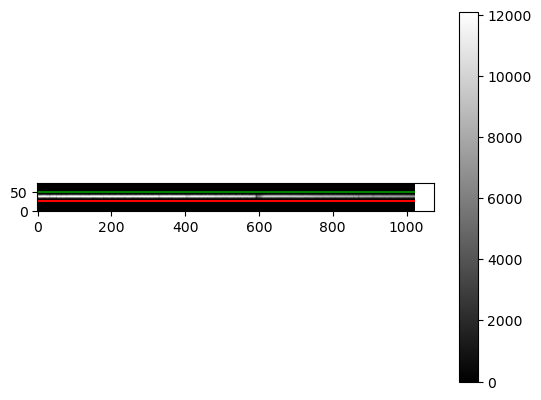

In [38]:
std_star_rec = rectify(std_star)
plot_data(std_star_rec)

plt.hlines(l_bound_s, 0, std_star_rec.shape[1], color = "red")
plt.hlines(r_bound_s, 0, std_star_rec.shape[1], color = "green")

18. Calculate the median along the vertical axis of your combined background apertures. **Plot the median background signal against wavelength.**

In [39]:
sky_reduced = []
star_pixels = r_bound - l_bound
for i in range(std_star_rec.shape[1]):
    col = std_star_rec[:,i]
    col_sky_l = col[0:l_bound_s]
    col_sky_r = col[r_bound_s:std_star_rec.shape[0]]
    col_sky = np.append(col_sky_l,col_sky_r)
    sky_r = np.median(col_sky)
    sky_reduced.append(sky_r * star_pixels)
sky_reduced = np.asarray(sky_reduced)
sky_reduced.shape


(1024,)

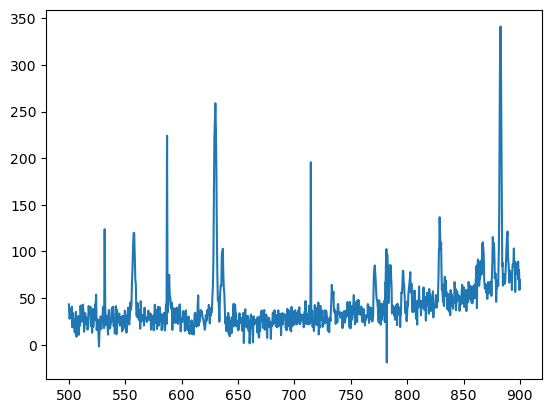

In [40]:
plt.plot(wavelenths, sky_reduced)

19. Multiply the background by the number of rows you summed over for the one-dimensional stellar spectrum, apply the airmass correction, and subtract it from the one-dimensional stellar spectrum. **Plot the background-subtracted one-dimensional stellar spectrum.**

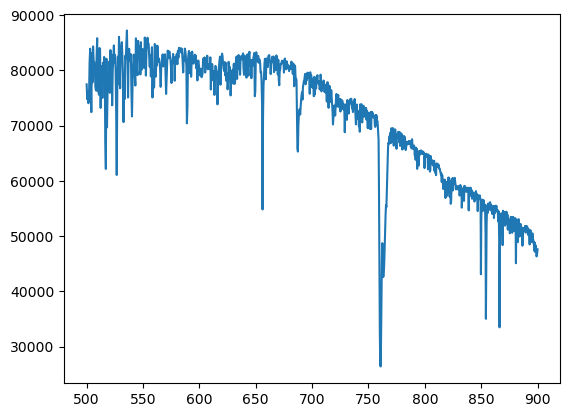

In [41]:
spectra_reduced_no_sky = spectra_reduced - sky_reduced
plt.plot(wavelenths, spectra_reduced_no_sky)

In [42]:
'''Function to get you a 1d spectra from a rectangle while showing you the steps along the way'''
def rectify_to_1d(rec_spectra, plot = False, scaler = 3, scaler_s = 5):
    star_vertical = np.median(rec_spectra, axis = 1)
    p = np.arange(len(star_vertical))

    model = GaussianModel()
    params = model.guess(star_vertical, x = p)
    result = model.fit(star_vertical, params, x = p)

    if(plot):
        result.plot_fit()
        plt.show()

    gauss_c = result.params["center"]
    gauss_s = result.params["sigma"]

    l_bound = int(np.ceil(gauss_c - scaler * gauss_s))
    r_bound = int(np.floor(gauss_c + scaler * gauss_s))

    l_bound_s = int(np.floor(gauss_c - scaler_s * gauss_s))
    r_bound_s = int(np.ceil(gauss_c + scaler_s * gauss_s))

    if(plot):
        plot_data(rec_spectra)

        plt.hlines(l_bound_s, 0, rec_spectra.shape[1], color = "red")
        plt.hlines(r_bound_s, 0, rec_spectra.shape[1], color = "red")

        plt.hlines(l_bound, 0, rec_spectra.shape[1], color = "green")
        plt.hlines(r_bound, 0, rec_spectra.shape[1], color = "green")

        plt.title("Aperatures on Rectified spectra")
        plt.show()

    if(plot):
        plt.plot(p, star_vertical)

        plt.vlines(l_bound, np.min(star_vertical), np.max(star_vertical), color = "green")
        plt.vlines(r_bound, np.min(star_vertical), np.max(star_vertical), color = "green")

        plt.vlines(l_bound_s, np.min(star_vertical), np.max(star_vertical), color = "red")
        plt.vlines(r_bound_s, np.min(star_vertical), np.max(star_vertical), color = "red")

        plt.title("Aperatures on collapsed spectra")
        plt.show()

    spectra_star = []
    spectra_sky = []
    star_pixels = r_bound - l_bound
    for i in range(rec_spectra.shape[1]):
        col = rec_spectra[:,i]
        col_star = col[l_bound:r_bound]
        col_sky_l = col[0:l_bound_s]
        col_sky_r = col[r_bound_s:rec_spectra.shape[0]]
        col_sky = np.append(col_sky_l,col_sky_r)
        sky_r = np.median(col_sky)
        spectra_sky.append(star_pixels * sky_r)
        star_s = np.sum(col_star)
        spectra_star.append(star_s)
    spectra_star = np.asarray(spectra_star)
    spectra_sky = np.asarray(spectra_sky)
    spectra_reduced = spectra_star - spectra_sky

    if(plot):
        plt.title("Sky Spectra")
        plt.plot(wavelenths, spectra_sky)
        plt.show()

        plt.title("Star Spectra")
        plt.plot(wavelenths, spectra_star)
        plt.show()

        plt.title("Reduced Spectra")
        plt.plot(wavelenths, spectra_reduced)
        plt.show()

    return spectra_reduced
    
    

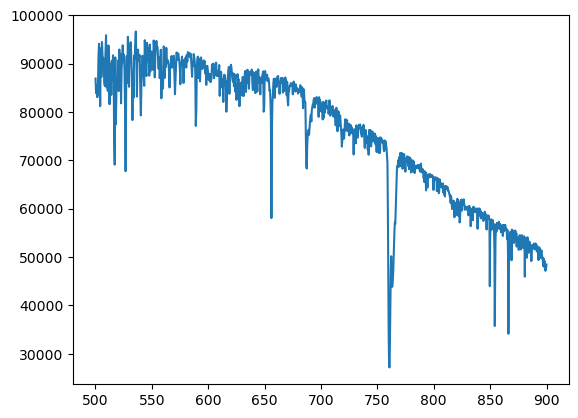

In [43]:
spectra_standard_star = F0(rectify_to_1d(std_star_rec, plot = False),mauna_kea_interp)
plt.plot(wavelenths, spectra_standard_star)
plt.show()

## Calibration

20. The reference file `G2V.fits` contains a zero-airmass calibrated spectrum of the same stellar type as the observed calibration star. We can use this to calculate the calibration to turn detector $\mathrm{counts}\,{\mathrm{s}^{-1}}$ into physical units (in this case, spectral irradiance $\mathrm{W}\,\mathrm{m^{-2}}\,\mathrm{nm^{-1}}$). Open the reference file and get the spectral irradiance (the `PRIMARY` extension) and wavelength. Pay close attention to the units! These are listed in the headers for each extension. Convert the wavelengths to nanometers and the spectral irradiance to $\mathrm{W}\,\mathrm{m^{-2}}\,\mathrm{nm^{-1}}$. **Plot the reference star stellar irradiance against wavelength.**

In [44]:
G2V_file = fits.open("problemset3data/reference/G2V.fits")
G2V_l = (G2V_file[1].data * u.AA).to(u.nm)
G2V_f = (G2V_file[0].data * u.erg / u.second / (u.cm)**3).to(u.W / ((u.m)**2 * u.nm))


Text(0, 0.5, 'Spectral Irradiance')

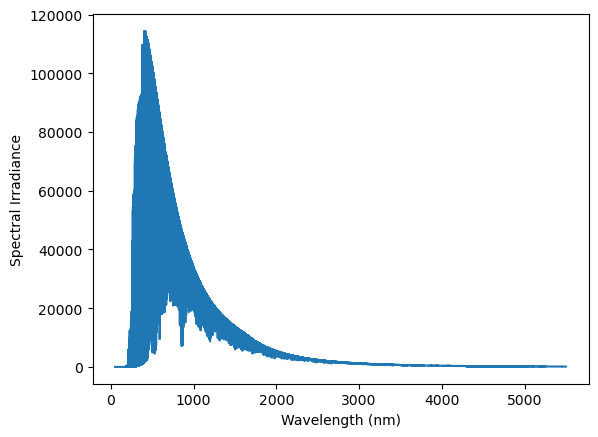

In [45]:
plt.plot(G2V_l, G2V_f)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Spectral Irradiance")

21. You also want to scale this flux to the distance of the star at the time of observation. The flux as reported in the reference FITS file is at the surface of the star. In order to scale it, you want to multiply it by the star's surface area, then divide it by the surface area of a sphere with a radius of the observation distance:
$F = F_0\left(\frac{4\pi R_\mathrm{star}^2}{4\pi d^2}\right).$<br>
The stellar radius is listed in the header. For the distance to the star, use $d = 300\,\mathrm{ly}$. Be careful with units! **Plot the reference stellar flux as observed from a distance of 300 lightyears.**

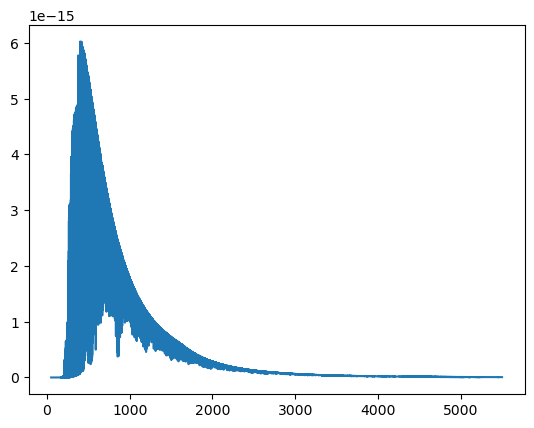

In [46]:
star_distance = 300 * u.lyr
star_radius = G2V_file[1].header["PHXREFF"] * u.cm
def scale_flux(Flux_0, R_star, d):
    return Flux_0 * (R_star**2 / d**2).si

stellar_flux = scale_flux(G2V_f, star_radius, star_distance)
plt.plot(G2V_l, stellar_flux)

22. Telescopes measure photons per second, not watts, so we'll want to convert to photon flux. Remember that $c=\lambda\nu$ where $c$ is the speed of light, $\lambda$ is the photon wavelength and $\nu$ is the photon frequency. Also remember the energy of a photon is $E = h\nu$ where $E$ is the energy, $h$ is Planck's constant and $\nu$ is again the photon frequency. Convert your stellar irradiance to photon flux $\mathrm{photons}\,\mathrm{s^{-1}}\,\mathrm{m^{-2}}\,\mathrm{nm^{-1}}$. **Plot photon flux against wavelength.**

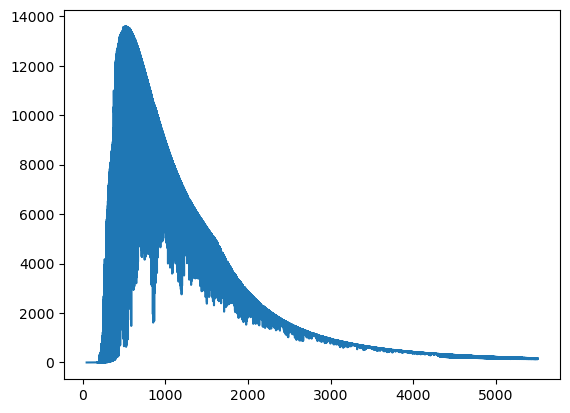

In [47]:
def wavelength_to_E(l):
    return (const.c * const.h / (l.si * u.photon))

w_energy = wavelength_to_E(G2V_l)
w_photons = (stellar_flux/w_energy).to(u.photon/(u.second * u.meter**2 * u.nm))
plt.plot(G2V_l, w_photons)

23. Finally, we need to rebin the reference flux to match the resolution of the spectrograph. Your wavelength solution has a $\Delta\lambda$ spacing at each wavelength. Calculate what the edges are of each pixel in $\mathrm{nm}$ (e.g., if the central wavelength from the solution is $\lambda$ and the spacing between the central wavelength and the adjacent wavelengths is $\Delta\lambda$, then the edges are $\lambda \pm \Delta\lambda/2$). Each bin should contain the **sum** of the photon flux that falls within it. Your resulting data should have units of $\mathrm{photons/s}$.<br><br>
You'll also want to get rid of that pesky $\mathrm{m^{-2}}$ and $\mathrm{nm^{-1}}$ before you rebin. The telescope collects as many photons as the area of the mirror, so multiply by the mirror area. It's a circular mirror, 10 meters across. The wavelength spacing $\Delta\lambda$ of each bin tells you how many nanometers it is across, so multiply by that to remove the wavelength dependence. Be careful though! $\Delta\lambda$ is not a constant. **Plot the rebinned photon flux against wavelength.**

In [48]:
wavelenths

array([500.11043473, 500.63143316, 501.15211902, ..., 899.33677411,
       899.62709427, 899.9172753 ])

24. Dividing Calculate the flux calibration by dividing your result by the observed spectrum. This will give you a conversion between photons and counts. To calibrate any future one-dimensional spectrum, you just need to multiply by this calibration to convert from counts to photons. **Plot the flux calibration against wavelength.**

In [49]:
w_photons_total = w_photons * np.pi * (5 * u.m)**2
l_bins = l_model.eval(l_params, x = np.arange(0,len(oned_spectra_norm) + 1) - 0.5) * u.nm

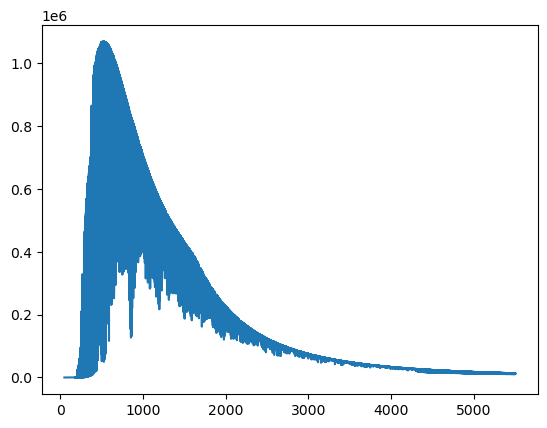

In [50]:
plt.plot(G2V_l, w_photons_total)

In [51]:
DELTA_L_CAL = np.roll(G2V_l, -1) - G2V_l
DELTA_L_CAL[-1] = DELTA_L_CAL[-2]

In [52]:
DELTA_L_CAL

<Quantity [0.01 , 0.01 , 0.01 , ..., 0.025, 0.025, 0.025] nm>

In [53]:
binned_spectra = []
for i in range(len(l_bins) - 1):
    bin_l = l_bins[i]
    bin_r = l_bins[i+1]
    delta_l = bin_r - bin_l
    indexes = np.where((G2V_l > bin_l) & (G2V_l < bin_r))[0]
    bin = w_photons_total[indexes] * DELTA_L_CAL[indexes]
    bin_s = np.sum(bin)
    binned_spectra.append(bin_s.value)
binned_spectra = np.asarray(binned_spectra) * (u.photon / u.second)


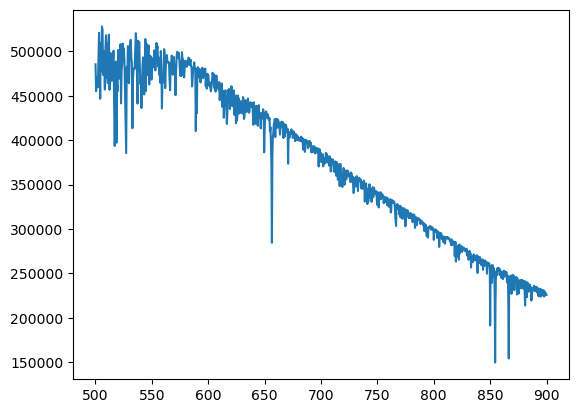

In [54]:
plt.plot(wavelenths, binned_spectra)

<Quantity [5.5859335 , 5.4271828 , 5.50973923, ..., 4.77245442, 4.75771442,
           4.6541383 ] ph / ct>

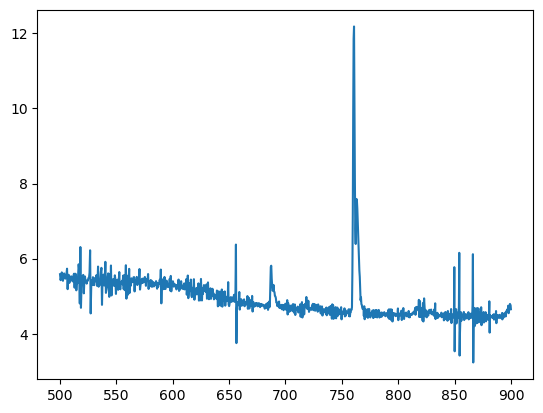

In [55]:
spectra_standard_star_u = spectra_standard_star * u.count/u.second
calibration_spectra = binned_spectra/spectra_standard_star_u
plt.plot(wavelenths, calibration_spectra)
calibration_spectra

# Part VI: Scientific Data Analysis

25. Load the science data and reduce it, apply the airmass correction, then median combine all of the science images together to eliminate any cosmic ray contamination. Don't calibrate it yet. Define an aperture for your science data. **Display your reduced, rectified science data and plot your aperture on top of it.**

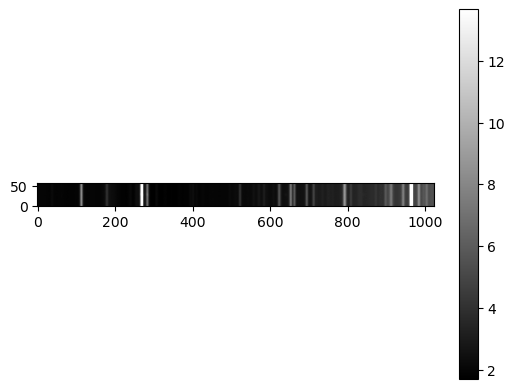

In [56]:
ganymede_obs = Obslog[np.where(Obslog["objid"] == "GANYMEDE")]
ganymede_img = []
for i in ganymede_obs:
    ganymede_img.append((read_file(i["File"]) - bias) / i["exptime"] / flat)
ganymede_img = np.asarray(ganymede_img)
ganymede_master = np.median(ganymede_img, axis=0)
ganymede_rec = rectify(ganymede_master)[10:70]
plot_data(ganymede_rec)

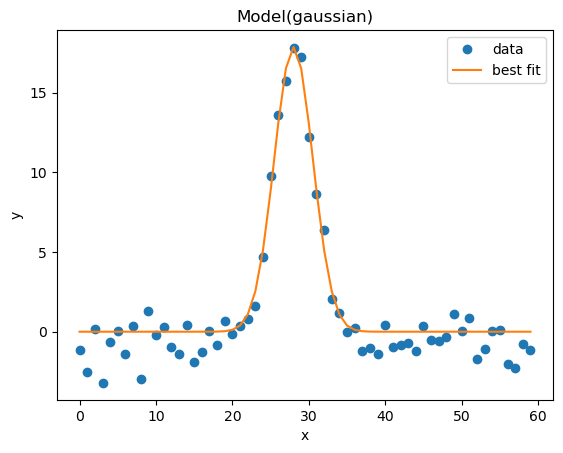

In [57]:
star_vertical = np.sum(ganymede_rec, axis = 1)
star_vertical = (star_vertical - np.median(star_vertical))
p = np.arange(len(star_vertical))

model = GaussianModel()
params = model.guess(star_vertical, x = p)
result = model.fit(star_vertical, params, x = p)


#plt.plot(star_vertical)
result.plot_fit()
plt.show()

gauss_c = result.params["center"]
gauss_s = result.params["sigma"]

l_bound = int(np.ceil(gauss_c - scaler * gauss_s))
r_bound = int(np.floor(gauss_c + scaler * gauss_s))

l_bound_s = int(np.floor(gauss_c - scaler_s * gauss_s))
r_bound_s = int(np.ceil(gauss_c + scaler_s * gauss_s))

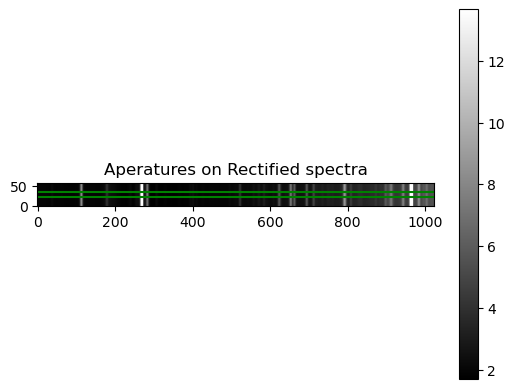

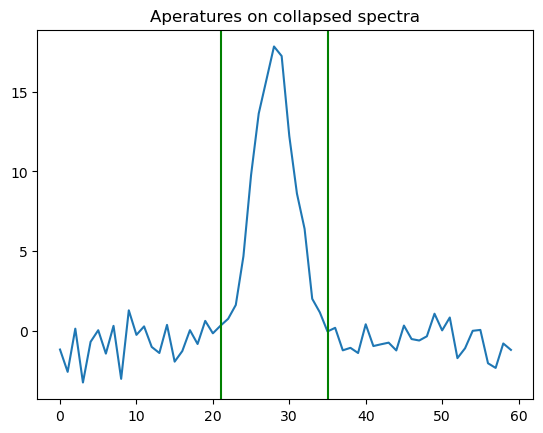

In [98]:
plot_data(ganymede_rec)

#plt.hlines(l_bound_s, 0, ganymede_rec.shape[1], color = "red")
#plt.hlines(r_bound_s, 0, ganymede_rec.shape[1], color = "red")

plt.axhline(l_bound, color = "green")
plt.axhline(r_bound, color = "green")

plt.title("Aperatures on Rectified spectra")
plt.show()

plt.plot(p, star_vertical)

plt.axvline(l_bound, color = "green")
plt.axvline(r_bound, color = "green")

#plt.vlines(l_bound_s, np.min(star_vertical), np.max(star_vertical), color = "red")
#plt.vlines(r_bound_s, np.min(star_vertical), np.max(star_vertical), color = "red")

plt.title("Aperatures on collapsed spectra")
plt.show()

26. Calculate the total counts in the aperture for each wavelength. **Plot the one-dimensional science data spectrum against wavelength.**

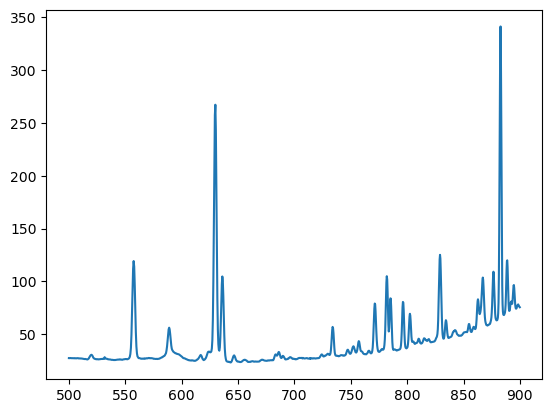

In [59]:
spectra_star = []
spectra_sky = []
star_pixels = r_bound - l_bound
for i in range(ganymede_rec.shape[1]):
    col = ganymede_rec[:,i]
    col_star = col[l_bound:r_bound]
    col_sky_l = col[0:l_bound_s]
    col_sky_r = col[r_bound_s:ganymede_rec.shape[0]]
    col_sky = np.append(col_sky_l,col_sky_r)
    sky_r = np.median(col_sky)
    spectra_sky.append(star_pixels * sky_r)
    star_s = np.sum(col_star)
    spectra_star.append(star_s)
spectra_star = np.asarray(spectra_star)
spectra_sky = np.asarray(spectra_sky)
spectra_reduced = spectra_star - spectra_sky

plt.plot(wavelenths, spectra_star)

27. Like you did with the calibration star, define a background aperture. **Display the reduced, rectified data and plot the background aperture on top of it.**

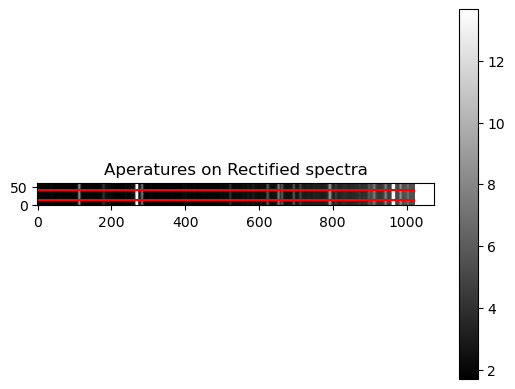

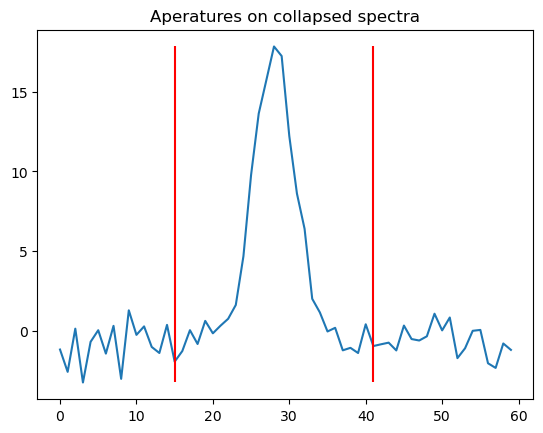

In [60]:
plot_data(ganymede_rec)

plt.hlines(l_bound_s, 0, ganymede_rec.shape[1], color = "red")
plt.hlines(r_bound_s, 0, ganymede_rec.shape[1], color = "red")

#plt.hlines(l_bound, 0, ganymede_rec.shape[1], color = "green")
#plt.hlines(r_bound, 0, ganymede_rec.shape[1], color = "green")

plt.title("Aperatures on Rectified spectra")
plt.show()

plt.plot(p, star_vertical)

#plt.vlines(l_bound, np.min(star_vertical), np.max(star_vertical), color = "green")
#plt.vlines(r_bound, np.min(star_vertical), np.max(star_vertical), color = "green")

plt.vlines(l_bound_s, np.min(star_vertical), np.max(star_vertical), color = "red")
plt.vlines(r_bound_s, np.min(star_vertical), np.max(star_vertical), color = "red")

plt.title("Aperatures on collapsed spectra")
plt.show()

28. Calculate the median one-dimensional background spectrum. **Plot the background spectrum against wavelength.**

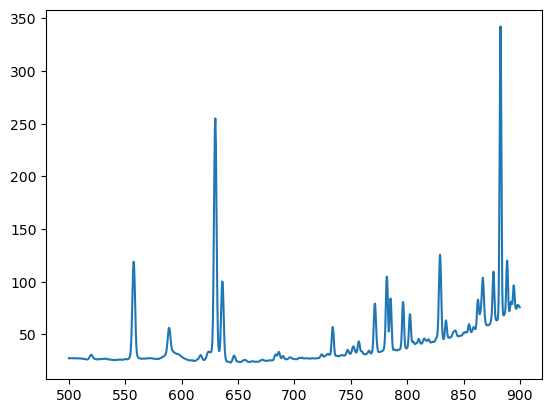

In [61]:
plt.plot(wavelenths, spectra_sky)

29. Calculate the expected background in your science aperture by multiplying by the number of rows in your science aperture. Remove the background from your science data and calibrate it. **Plot your calibrated science spectrum against wavelength.**

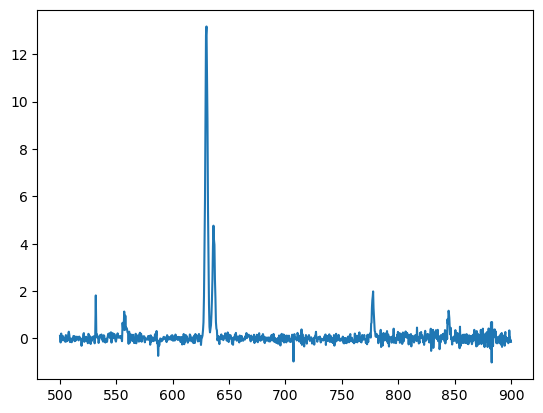

In [62]:
#plt.plot(wavelenths, spectra_reduced)
spectra_reduced_F0 = F0(spectra_reduced, mauna_kea_interp) * u.count/u.second
plt.plot(wavelenths, spectra_reduced_F0)

<Quantity [ 0.63138548, -0.91735788,  1.13820809, ..., -0.70749978,
           -0.30303984, -0.65312922] ph / s>

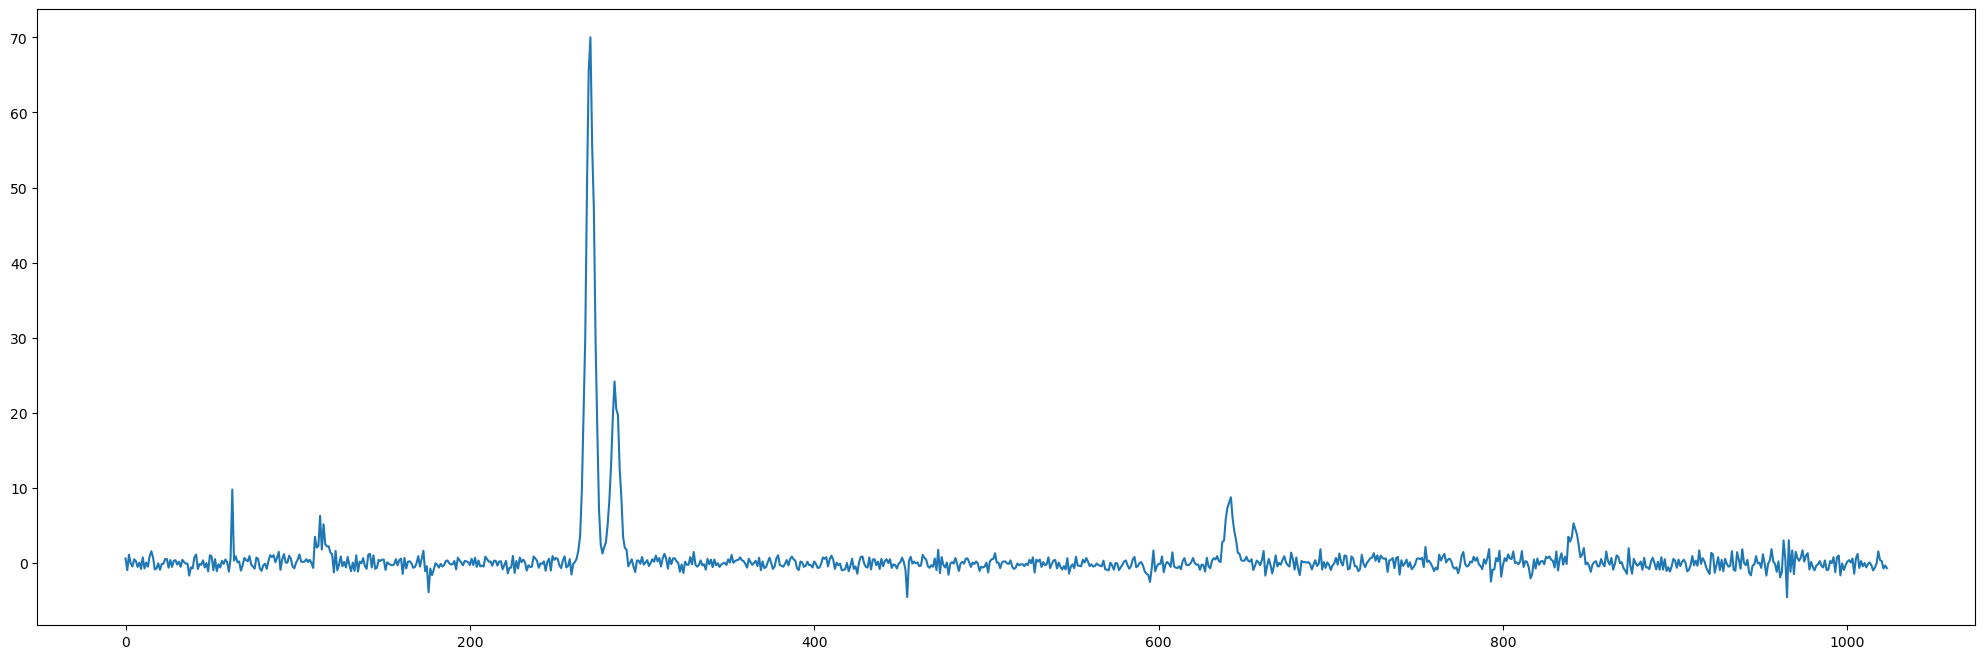

In [63]:
ganymede_calibrated = spectra_reduced_F0 * calibration_spectra
plt.figure(figsize=(25,8))
plt.plot(ganymede_calibrated)
ganymede_calibrated

30. These spectra of Ganymede were taken when it was eclipsed by Jupiter. Oxygen aurora in the atmosphere should emit at 557.7 nm, 630.0 nm, 636.4 nm, 777.4 nm and 844.6 nm. Identify these wavelength locations and see if you can see any peaks there. **Plot the calibrated science data and show the location of the possible oxygen aurora.**

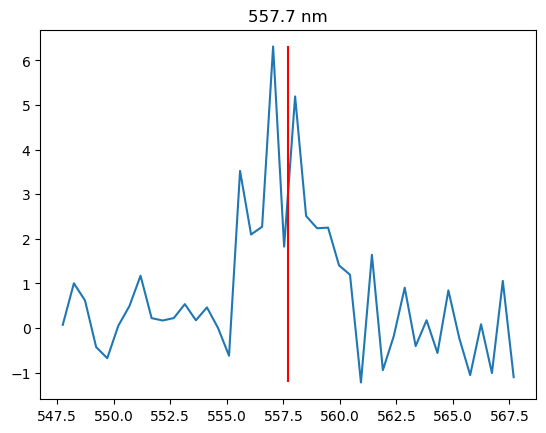

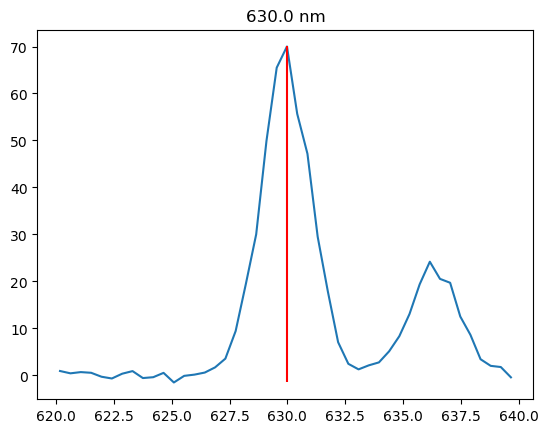

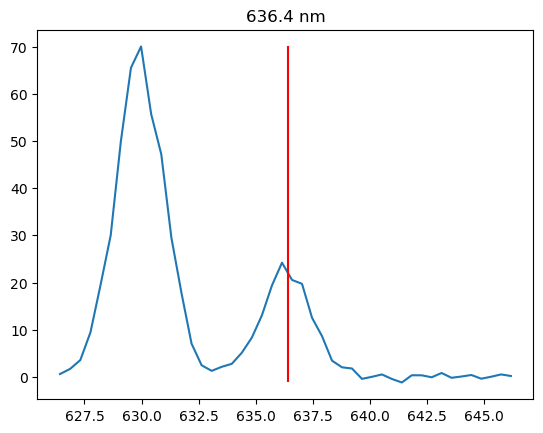

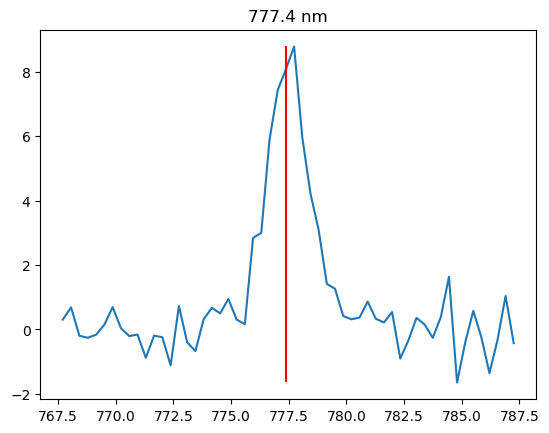

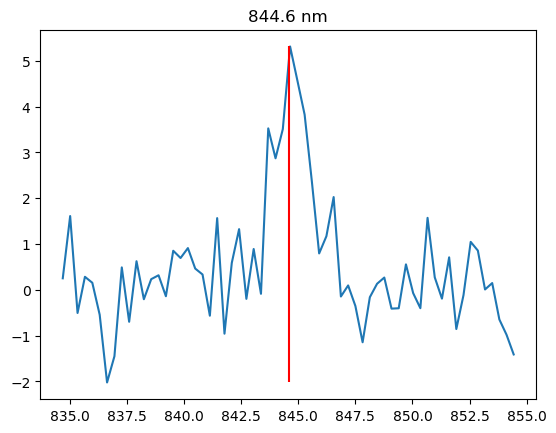

In [64]:
l_of_interest = np.array([557.7, 630, 636.4, 777.4, 844.6]) * u.nm
wavelengths_units = wavelenths * u.nm
window = 10 * u.nm #4 will be optimal for fitting

for i in l_of_interest:
    section = np.where((wavelengths_units > i - window) & (wavelengths_units < i + window))[0]
    l_section = wavelengths_units[section]
    f_section = ganymede_calibrated[section]
    plt.plot(l_section, f_section)
    plt.vlines(i.value, np.min(f_section).value, np.max(f_section).value, color = "red")
    plt.title(str(i))
    plt.show()

31. Fit a Gaussian to each peak, then integrate it to get the total photon flux in each line. **Display the calibrated spectrum and over-plot your Gaussian fits.**

In [87]:
delta_wavelenth = np.roll(wavelenths, -1) - wavelenths
delta_wavelenth[-1] = delta_wavelenth[-2]
delta_wavelenth

array([0.52099843, 0.52068586, 0.52037346, ..., 0.29032016, 0.29018103,
       0.29018103])

In [65]:
def integrate_gaussian(sigma, height):
    return  height*sigma*np.sqrt(2 * np.pi)

<Parameter 'sigma', value=3.0170416939175766 +/- 0.574, bounds=[0.0:inf]> <Parameter 'height', value=4.10513607153849 +/- 0.677, bounds=[-inf:inf], expr='0.3989423*amplitude/max(1e-15, sigma)'>


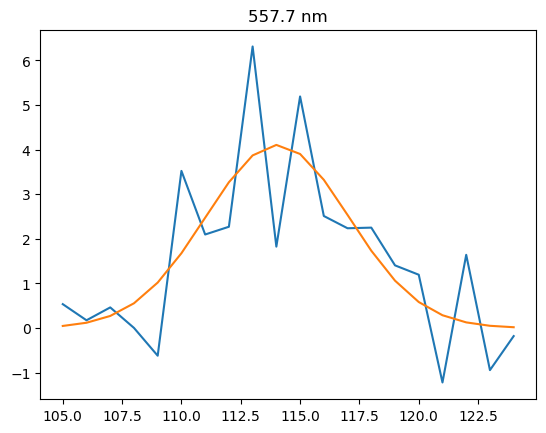

<Parameter 'sigma', value=2.4208492473734995 +/- 0.0699, bounds=[0.0:inf]> <Parameter 'height', value=67.56401414808482 +/- 1.69, bounds=[-inf:inf], expr='0.3989423*amplitude/max(1e-15, sigma)'>


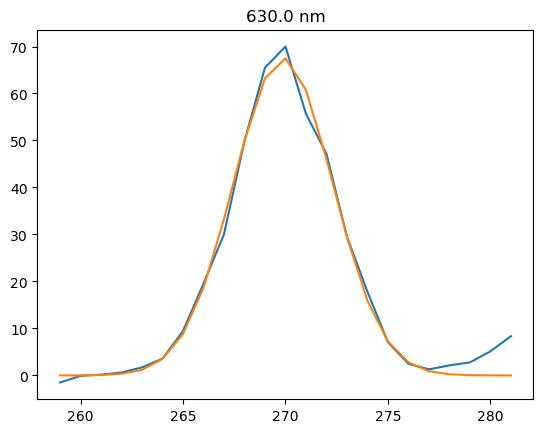

<Parameter 'sigma', value=2.499937781444767 +/- 0.334, bounds=[0.0:inf]> <Parameter 'height', value=22.73627140464275 +/- 2.63, bounds=[-inf:inf], expr='0.3989423*amplitude/max(1e-15, sigma)'>


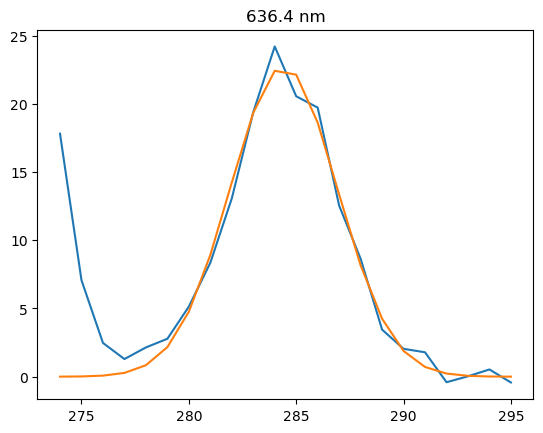

<Parameter 'sigma', value=2.534647638865126 +/- 0.117, bounds=[0.0:inf]> <Parameter 'height', value=8.343951033688159 +/- 0.332, bounds=[-inf:inf], expr='0.3989423*amplitude/max(1e-15, sigma)'>


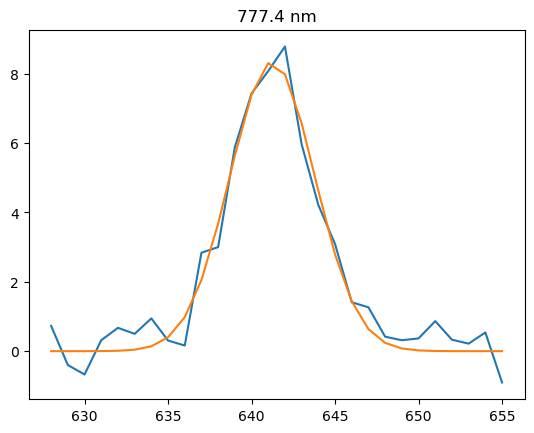

<Parameter 'sigma', value=2.586089665754518 +/- 0.289, bounds=[0.0:inf]> <Parameter 'height', value=4.693923600340929 +/- 0.454, bounds=[-inf:inf], expr='0.3989423*amplitude/max(1e-15, sigma)'>


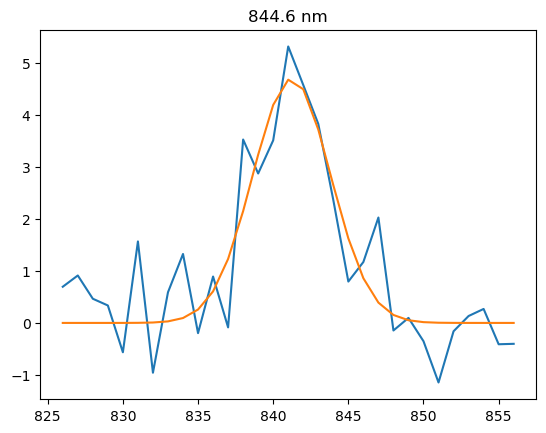

In [90]:
l_of_interest = np.array([557.7, 630, 636.4, 777.4, 844.6]) * u.nm
wavelengths_units = wavelenths * u.nm
window = 5 * u.nm #4 will be optimal for fitting
integrals = []
integrals_sum = []

for i in l_of_interest:
    section = np.where((wavelengths_units > i - window) & (wavelengths_units < i + window))[0]
    l_section = section * u.pix
    f_section = ganymede_calibrated[section]

    model = GaussianModel()
    params = model.guess(f_section.value, x = l_section.value)
    result = model.fit(f_section.value, params, x = l_section.value)

    x_model, step = np.linspace(l_section[0], l_section[-1], 1000, retstep = True)
    x_model = x_model.value
    output = model.eval(result.params, x = l_section.value)

    integrals_sum.append(np.sum(output))

    integrals.append(integrate_gaussian(result.params["sigma"], result.params["height"]))
    print(result.params["sigma"], result.params["height"])

    plt.plot(l_section, f_section)
    plt.plot(l_section.value, output)
    #plt.vlines(i.value, np.min(f_section).value, np.max(f_section).value, color = "red")
    plt.title(str(i))
    plt.show()

In [91]:
integrals = np.asarray(integrals) * u.photon/u.second
integrals 

<Quantity [ 31.04551033, 409.9898678 , 142.47490599,  53.01262069,
            30.4277283 ] ph / s>

In [76]:
integrals_sum * u.photon/u.second

<Quantity [ 31.01393298, 409.98782926, 142.4543308 ,  53.0144306 ,
            30.42881089] ph / s>

In [78]:
integrals_sum/integrals

<Quantity [2.05308582, 2.25764867, 2.27748989, 2.8126448 , 3.14291847] s / ph>

32. Calculate the following flux ratios:<br><br>
&nbsp; &nbsp; &nbsp; &nbsp; 1\. (630.0 nm + 636.4 nm) / 557.7 nm<br>
&nbsp; &nbsp; &nbsp; &nbsp; 2\. (630.0 nm + 636.4 nm) / 777.4 nm<br>
&nbsp; &nbsp; &nbsp; &nbsp; 3\. (630.0 nm + 636.4 nm) / 844.6 nm<br>

**Print out the ratios.** If you can, estimate uncertainties and report them with your ratios (not required for full credit).

In [92]:
numerator = integrals[1] + integrals[2]
ratio1 = numerator / integrals[0]
ratio2 = numerator / integrals[3]
ratio3 = numerator / integrals[4]
print(ratio1, ratio2, ratio3)

17.795319449383733 10.421382052736925 18.15662241913489


33. Data similar to these are published in [de Kleer et al (2023)](https://doi.org/10.3847/PSJ/acb53c). Compare your ratios to those in table 5. **Which atmospheric species is likely to be the source of the atomic oxygen emitting the aurora?**

It would appear that it is $O_2$

34. Calculate the brightness of each line in units of rayleighs. The rayleigh is symbolically represented by R and has base units of<br><br>
$$
1\,\mathrm{R} = \frac{10^{10}}{4\mathrm{\pi}}\,\mathrm{photons\,s^{-1}\,m^{-2}\,sr^{-1}}.
$$<br>
Propagate uncertainties if you can (also not required for full credit). **Print out the calibrated brightnesses for each aurora line in rayleighs.** How do your brightnesses compare to those found by de Kleer et al. (2023)?

In [93]:
ganymede_obs

File,UTC,ra,dec,targetid,objid,airmass,exptime,obstype
str64,str64,str64,str64,str64,str64,float64,float64,str64
./problemset3data/science03.fits,2021-06-08T13:51:20.129,22:15:55.2,333:58:47.5,GANYMEDE,GANYMEDE,1.3,300.0597,SCIENCE
./problemset3data/science00.fits,2021-06-08T13:34:49.596,22:15:54.9,333:58:43.1,GANYMEDE,GANYMEDE,1.352,300.0336,SCIENCE
./problemset3data/science04.fits,2021-06-08T13:56:50.293,22:15:55.3,333:58:48.9,GANYMEDE,GANYMEDE,1.285,300.1228,SCIENCE
./problemset3data/science02.fits,2021-06-08T13:45:49.925,22:15:55.1,333:58:46.0,GANYMEDE,GANYMEDE,1.316,300.1211,SCIENCE
./problemset3data/science01.fits,2021-06-08T13:40:19.799,22:15:55.0,333:58:44.6,GANYMEDE,GANYMEDE,1.334,300.0731,SCIENCE


In [94]:
angular_diameter = 1.551494 * u.arcsec
surface_area = ((angular_diameter/2)**2 * np.pi).to(u.sr)
surface_area

<Quantity 4.4436497e-11 sr>

In [95]:
((integrals / (np.pi * (5 * u.m)**2)) / surface_area).to(u.R)

<Quantity [ 11.1783826 , 147.62274983,  51.30013948,  19.08795669,
            10.95594129] R>

My numbers are very close to what is reported in the paper in table 2

35. How much time did you spent working on this problem set (including time spent in office hours)?

In [96]:
print("20 ish hours?")

20 ish hours?
